# Homework 3

## Part 1: Imbalanced Dataset
This part of homework helps you practice to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. 

### Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

Due Date : TBD

### Name: Chandan Suri

### UNI: CS4090

## 0 Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

## 1 Data processing and exploration
Download the Kaggle Credit Card Fraud data set. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.1 Examine the class label imbalance
Let's look at the dataset imbalance:

**Q1. How many observations are there in this dataset? How many of them have positive label (labeled as 1)?**

In [6]:
target_feature_name = "Class"
credit_card_data_num_rows = len(raw_df)

# This will add up all the 1's in the class which is the label for the dataset.
# Summing all the 1's essentially gives us the number of positive labels in the dataset.
positive_labels_num = raw_df[target_feature_name].sum()

print(f"The number of observatons in the dataset: {credit_card_data_num_rows}")
print(f"The number of rows marked with Class 1 (positive label): {positive_labels_num}")

The number of observatons in the dataset: 284807
The number of rows marked with Class 1 (positive label): 492


### 1.2 Clean, split and normalize the data
The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [15]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

**Q2. Split the dataset into development and test sets. Please set test size as 0.2 and random state as 42.**

In [16]:
# Extract the label as separate variable and get the features as separate variable.
credit_card_cleaned_data_labels = cleaned_df[target_feature_name]
credit_card_cleaned_data_features = cleaned_df.drop(target_feature_name, axis = 1)

X_dev, X_test, y_dev, y_test = train_test_split(credit_card_cleaned_data_features,
                                                credit_card_cleaned_data_labels, 
                                                stratify = credit_card_cleaned_data_labels,
                                                test_size = 0.2,
                                                random_state = 42)

print(f"The shape of the Development Set Features: {X_dev.shape}")
print(f"The shape of the Testing Set Features: {X_test.shape}")
print(f"The shape of the Development Set Labels: {y_dev.shape}")
print(f"The shape of the Testing Set Labels: {y_test.shape}")

The shape of the Development Set Features: (227845, 29)
The shape of the Testing Set Features: (56962, 29)
The shape of the Development Set Labels: (227845,)
The shape of the Testing Set Labels: (56962,)


**Q3. Normalize the input features using the sklearn StandardScaler. Print the shape of your development features and test features.**

In [19]:
std_scaler = StandardScaler()

X_dev_scaled = pd.DataFrame(std_scaler.fit_transform(X_dev), columns = X_dev.columns)
X_test_scaled = pd.DataFrame(std_scaler.transform(X_test), columns = X_test.columns)

print(f"The shape of the Scaled Development Set Features: {X_dev_scaled.shape}")
print(f"The shape of the Scaled Testing Set Features: {X_test_scaled.shape}")

The shape of the Scaled Development Set Features: (227845, 29)
The shape of the Scaled Testing Set Features: (56962, 29)


### 1.3 Define the model and metrics
**Q4. First, fit a default logistic regression model. Print the AUC and average precision of 5-fold cross validation.**

###  TODO Might have to change the getting the estimator part...

In [20]:
# Additional Imports 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [41]:
lr_default_model = LogisticRegression()
scores = cross_validate(lr_default_model, X_dev_scaled, y_dev, 
                        cv = 5, scoring = ['roc_auc', 'average_precision'],
                        return_estimator = True)

print(f"The AUC values are as follows: {scores['test_roc_auc']}")
print(f"The AUC of the default Logistic Regression model is: {scores['test_roc_auc'].mean()}")
print(f"The Average Precision of the default Logistic Regression model is: " + \
      f"{scores['test_average_precision'].mean()}")

The AUC values are as follows: [0.96867681 0.98255313 0.96207234 0.97842981 0.99011106]
The AUC of the default Logistic Regression model is: 0.9763686302709351
The Average Precision of the default Logistic Regression model is: 0.7620017185050845


In [42]:
# Get the best fitted model
lr_default_model = scores['estimator'][3]

**Q5.1. Perform random under sampling on the development set. What is the shape of your development features? How many  positive and negative labels are there in your development set? (Please set random state as 42 when performing random under sampling)**

In [25]:
ru_sampler = RandomUnderSampler(replacement = False, random_state = 42)
X_dev_undersampled, y_dev_undersampled = ru_sampler.fit_resample(X_dev_scaled, y_dev)

print(f"The shape of the Development Features is: {X_dev_scaled.shape} ")
print(f"The shape of the Development Features after Under Sampling is: {X_dev_undersampled.shape}")
print(f"The positive and negative labels are as follows: \n {y_dev_undersampled.value_counts()}")

The shape of the Development Features is: (227845, 29) 
The shape of the Development Features after Under Sampling is: (788, 29)
The positive and negative labels are as follows: 
 0    394
1    394
Name: Class, dtype: int64


**Q5.2. Fit a default logistic regression model using under sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random under sampling)**

In [50]:
ru_sampler = RandomUnderSampler(replacement = False, random_state = 42)
lr_under_sampled_pipeline = imb_make_pipeline(ru_sampler, LogisticRegression())

scores = cross_validate(lr_under_sampled_pipeline, X_dev_scaled, y_dev, 
                        cv = 5, scoring = ['roc_auc', 'average_precision'],
                        return_estimator = True)

print(f"The AUC values are as follows: {scores['test_roc_auc']}")
print(f"The AUC of the default Logistic Regression model (& Under Sampling) is: " + \
      f"{scores['test_roc_auc'].mean()}")
print(f"The Average Precision of the default Logistic Regression model (& Under Sampling) is: " + \
      f"{scores['test_average_precision'].mean()}")

The AUC values are as follows: [0.96614574 0.9753319  0.98044194 0.97379755 0.99099009]
The AUC of the default Logistic Regression model (& Under Sampling) is: 0.9773414443783114
The Average Precision of the default Logistic Regression model (& Under Sampling) is: 0.5687868062162817


In [54]:
# Get the Under sampled model from the pipeline
lr_under_sampled_model = scores['estimator'][3][1]

**Q6.1. Perform random over sampling on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing random over sampling)**

In [30]:
ro_sampler = RandomOverSampler(random_state = 42)
X_dev_oversampled, y_dev_oversampled = ro_sampler.fit_resample(X_dev_scaled, y_dev)

print(f"The shape of the Development Features is: {X_dev_scaled.shape} ")
print(f"The shape of the Development Features after Over Sampling is: {X_dev_oversampled.shape}")
print(f"The positive and negative labels are as follows: \n {y_dev_oversampled.value_counts()}")

The shape of the Development Features is: (227845, 29) 
The shape of the Development Features after Over Sampling is: (454902, 29)
The positive and negative labels are as follows: 
 0    227451
1    227451
Name: Class, dtype: int64


**Q6.2. Fit a default logistic regression model using over sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random over sampling)**

In [57]:
ro_sampler = RandomOverSampler(random_state = 42)
lr_over_sampled_pipeline = imb_make_pipeline(ro_sampler, LogisticRegression())

scores = cross_validate(lr_over_sampled_pipeline, X_dev_scaled, y_dev, 
                        cv = 5, scoring = ['roc_auc', 'average_precision'],
                       return_estimator = True)

print(f"The AUC values are as follows: {scores['test_roc_auc']}")
print(f"The AUC of the default Logistic Regression model (& Over Sampling) is: " + \
      f"{scores['test_roc_auc'].mean()}")
print(f"The Average Precision of the default Logistic Regression model (& Over Sampling) is: " + \
      f"{scores['test_average_precision'].mean()}")

The AUC values are as follows: [0.95932134 0.98132348 0.98764035 0.98166547 0.99338205]
The AUC of the default Logistic Regression model (& Over Sampling) is: 0.9806665368543067
The Average Precision of the default Logistic Regression model (& Over Sampling) is: 0.7522653129344974


In [60]:
# Get the Over sampled model from the pipeline
lr_over_sampled_model = scores['estimator'][3][1]

**Q7.1. Perform Synthetic Minority Oversampling Technique (SMOTE) on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing SMOTE)**

In [32]:
smote_sampler = SMOTE(random_state = 42)
X_dev_smote_sampled, y_dev_smote_sampled = smote_sampler.fit_resample(X_dev_scaled, y_dev)

print(f"The shape of the Development Features is: {X_dev_scaled.shape} ")
print(f"The shape of the Development Features after SMOTE Sampling is: {X_dev_smote_sampled.shape}")
print(f"The positive and negative labels are as follows: \n {y_dev_smote_sampled.value_counts()}")

The shape of the Development Features is: (227845, 29) 
The shape of the Development Features after SMOTE Sampling is: (454902, 29)
The positive and negative labels are as follows: 
 0    227451
1    227451
Name: Class, dtype: int64


**Q7.2. Fit a default logistic regression model using SMOTE. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing SMOTE)**

In [65]:
smote_sampler = SMOTE(random_state = 42)
lr_smote_pipeline = imb_make_pipeline(smote_sampler, LogisticRegression())

scores = cross_validate(lr_smote_pipeline, X_dev_scaled, y_dev, 
                        cv = 5, scoring = ['roc_auc', 'average_precision'],
                        return_estimator = True)

print(f"The AUC values are as follows: {scores['test_roc_auc']}")
print(f"The AUC of the default Logistic Regression model (& SMOTE) is: " + \
      f"{scores['test_roc_auc'].mean()}")
print(f"The Average Precision of the default Logistic Regression model (& SMOTE) is: " + \
      f"{scores['test_average_precision'].mean()}")

The AUC values are as follows: [0.95776313 0.97980138 0.98119548 0.97971317 0.99339012]
The AUC of the default Logistic Regression model (& SMOTE) is: 0.9783726532901543
The Average Precision of the default Logistic Regression model (& SMOTE) is: 0.7509401146877034


In [66]:
# Get the model after applying SMOTE from the pipeline
lr_smote_model = scores['estimator'][3][1]

**Q8. Plot confusion matrices on the test set for all four models above. Comment on your result.**

In [44]:
from sklearn.metrics import plot_confusion_matrix
import warnings

warnings.filterwarnings("ignore")

The Confusion Matrix for default Logistic Regression Model without any sampling used: 


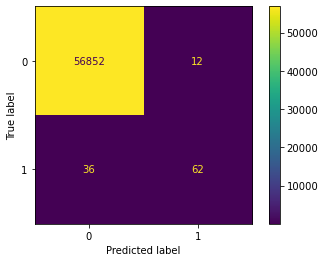

In [47]:
print(f"The Confusion Matrix for default Logistic Regression Model without any sampling used: ")
plot_confusion_matrix(lr_default_model, X_test_scaled, y_test)
plt.show()

The Confusion Matrix for default Logistic Regression Model with Under Sampling used: 


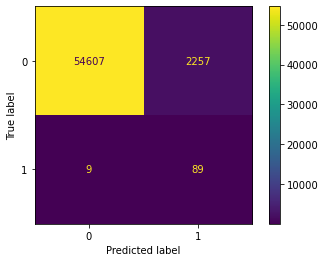

In [56]:
print(f"The Confusion Matrix for default Logistic Regression Model with Under Sampling used: ")
plot_confusion_matrix(lr_under_sampled_model, X_test_scaled, y_test)
plt.show()

The Confusion Matrix for default Logistic Regression Model with Over Sampling used: 


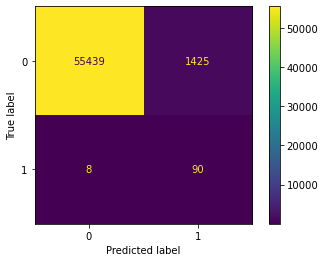

In [62]:
print(f"The Confusion Matrix for default Logistic Regression Model with Over Sampling used: ")
plot_confusion_matrix(lr_over_sampled_model, X_test_scaled, y_test)
plt.show()

The Confusion Matrix for default Logistic Regression Model with SMOTE used: 


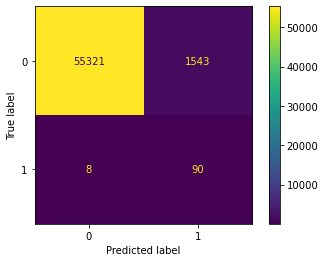

In [68]:
print(f"The Confusion Matrix for default Logistic Regression Model with SMOTE used: ")
plot_confusion_matrix(lr_smote_model, X_test_scaled, y_test)
plt.show()

Analysis of the Results:

**Q9. Plot the ROC for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

In [70]:
from sklearn.metrics import roc_curve

In [72]:
models_trained = {"Default Logistic Regression": lr_default_model,
                  "Logistic Regression Model with Under Sampling": lr_under_sampled_model,
                  "Logistic Regression Model with Over Sampling": lr_over_sampled_model,
                  "Logistic Regression Model with SMOTE": lr_smote_model}

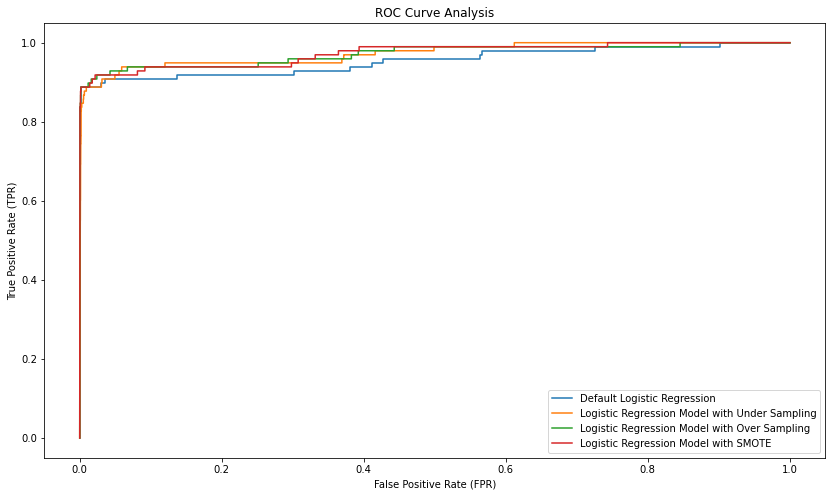

In [76]:
# Making predictions and plotting the ROC for all the models trained above...
fig = plt.figure(figsize = (14, 8))

for model_name, model in models_trained.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label = 1)
    
    plt.plot(fpr, tpr, label = f"{model_name}")
    
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Analysis")
plt.legend(loc = "lower right")
plt.show()

ROC Curve Analysis:

**Q10. Plot the precision-recall curve for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

In [95]:
from sklearn.metrics import precision_recall_curve

In [96]:
models_trained = {"Default Logistic Regression": lr_default_model,
                  "Logistic Regression Model with Under Sampling": lr_under_sampled_model,
                  "Logistic Regression Model with Over Sampling": lr_over_sampled_model,
                  "Logistic Regression Model with SMOTE": lr_smote_model}

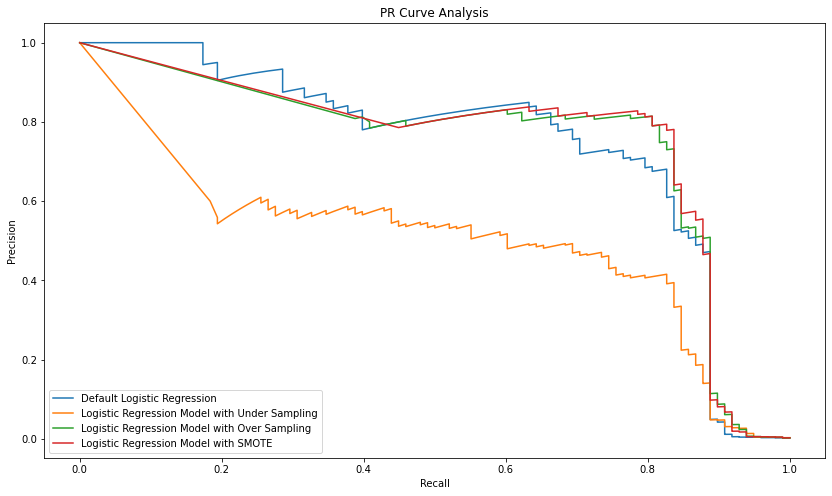

In [97]:
# Making predictions and plotting the PR Curve for all the models trained above...
fig = plt.figure(figsize = (14, 8))

for model_name, model in models_trained.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label = 1)
    
    plt.plot(recall, precision, label = f"{model_name}")
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve Analysis")
plt.legend(loc = "lower left")
plt.show()

PR Curve Analysis:

**Q11. Adding class weights to a logistic regression model. Print the AUC and average precision of 5-fold cross validation. Also, plot its confusion matrix on test set.**

In [83]:
from sklearn.linear_model import LogisticRegressionCV

In [84]:
scores = cross_validate(LogisticRegressionCV(class_weight = 'balanced'),
                        X_dev_scaled, y_dev, cv = 5, 
                        scoring = ['roc_auc', 'average_precision'],
                        return_estimator = True)

In [85]:
print(f"The AUC values are as follows: {scores['test_roc_auc']}")
print(f"The AUC of the Logistic Regression model with balanced class weights is: " + \
      f"{scores['test_roc_auc'].mean()}")
print(f"The Average Precision of the Logistic Regression model with balanced class weights is: " + \
      f"{scores['test_average_precision'].mean()}")

The AUC values are as follows: [0.97064593 0.98664333 0.98784877 0.97828456 0.99229431]
The AUC of the Logistic Regression model with balanced class weights is: 0.9831433795613979
The Average Precision of the Logistic Regression model with balanced class weights is: 0.7138384209738907


In [89]:
lr_class_weights_model = scores['estimator'][1]

The Confusion Matrix for Logistic Regression model with balanced class weights: 


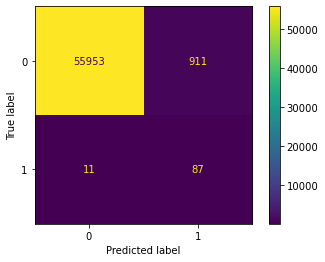

In [90]:
print(f"The Confusion Matrix for Logistic Regression model with balanced class weights: ")
plot_confusion_matrix(lr_class_weights_model, X_test_scaled, y_test)
plt.show()

**Q12. Plot the ROC and the precision-recall curve for default Logistic without any sampling method and this balanced Logistic model in two single plots. Make sure to label the axes and legend. Comment on your result.**

In [91]:
models_to_plot = {"Default Logistic Regression": lr_default_model,
                  "Logistic Regression model with Balanced Weights": lr_class_weights_model}

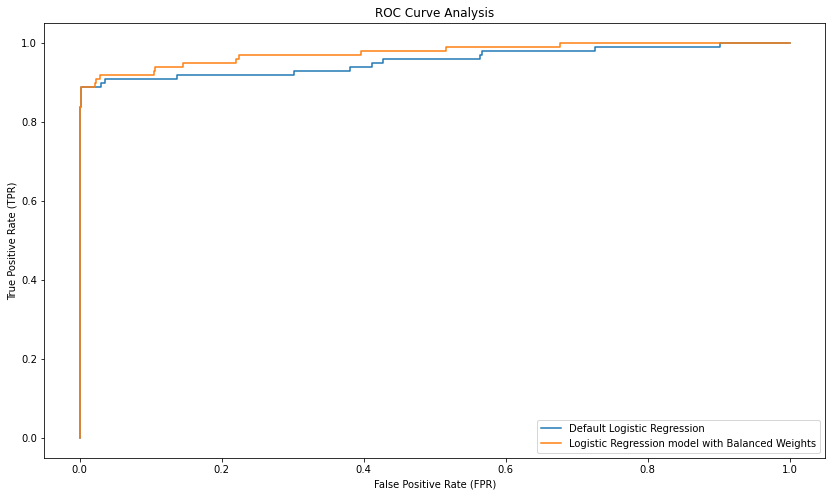

In [92]:
# Making predictions and plotting the ROC for 2 models above...
fig = plt.figure(figsize = (14, 8))

for model_name, model in models_to_plot.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label = 1)
    
    plt.plot(fpr, tpr, label = f"{model_name}")
    
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Analysis")
plt.legend(loc = "lower right")
plt.show()

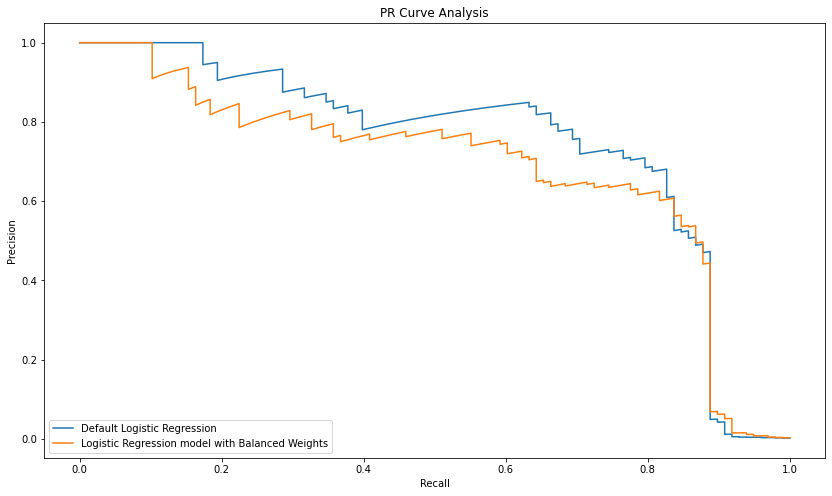

In [94]:
# Making predictions and plotting the PR Curve for 2 models above...
fig = plt.figure(figsize = (14, 8))

for model_name, model in models_to_plot.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label = 1)
    
    plt.plot(recall, precision, label = f"{model_name}")
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve Analysis")
plt.legend(loc = "lower left")
plt.show()

Curve Analysis:

## Part 2: Unsupervised Learning

In this part, we will be applying unsupervised learning approaches to a problem in computational biology. Specifically, we will be analyzing single-cell genomic sequencing data. Single-cell genomics is a set of revolutionary new technologies which can profile the genome of a specimen (tissue, blood, etc.) at the resolution of individual cells. This increased granularity can help capture intercellular heterogeneity, key to better understanding and treating complex genetic diseases such as cancer and Alzheimer's. 

<img src="https://cdn.10xgenomics.com/image/upload/v1574196658/blog/singlecell-v.-bulk-image.png" width="800px"/>

<center>Source: 10xgenomics.com/blog/single-cell-rna-seq-an-introductory-overview-and-tools-for-getting-started</center>

A common challenge of genomic datasets is their high-dimensionality: a single observation (a cell, in the case of single-cell data) may have tens of thousands of gene expression features. Fortunately, biology offers a lot of structure - different genes work together in pathways and are co-regulated by gene regulatory networks. Unsupervised learning is widely used to discover this intrinsic structure and prepare the data for further analysis.

### Dataset: single-cell RNASeq of mouse brain cells

We will be working with a single-cell RNASeq dataset of mouse brain cells. In the following gene expression matrix, each row represents a cell and each column represents a gene. Each entry in the matrix is a normalized gene expression count - a higher value means that the gene is expressed more in that cell. The dataset has been pre-processed using various quality control and normalization methods for single-cell data. 

Data source is on Coursework.

In [101]:
cell_gene_counts_df = pd.read_csv('data/mouse_brain_cells_gene_counts.csv', index_col='cell')
cell_gene_counts_df

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253000,...,1.3150,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2.MAA000902.3_11_M.1.1,14.98400,1.1550,-0.576,-0.2727,-0.4153,0.7530,-0.4692,-0.03146,-0.6035,-1.021000,...,1.4260,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.728
E2.MAA000926.3_9_M.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.4720,-0.4692,-0.03146,1.8120,1.079000,...,-0.7227,-0.2145,-0.1927,-0.4163,0.2422,-0.5913,-0.553,1.6060,-0.04385,-0.681
E2.MAA000932.3_11_M.1.1,-0.08093,0.5703,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-0.003473,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,2.074


Note the dimensionality - we have 1000 cells (observations) and 18,585 genes (features)!

We are also provided a metadata file with annotations for each cell (e.g. cell type, subtissue, mouse sex, etc.)

In [102]:
cell_metadata_df = pd.read_csv('data/mouse_brain_cells_metadata.csv')
cell_metadata_df

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0
...,...,...,...,...,...,...,...,...
995,E2.MAA000902.3_11_M.1.1,astrocyte,Striatum,M,3_11_M,MAA000902,3026,3134463.0
996,E2.MAA000926.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000926,3085,744301.0
997,E2.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2277,519257.0
998,E2.MAA000944.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000944,3234,1437895.0


Different cell types

In [103]:
cell_metadata_df['cell_ontology_class'].value_counts()

oligodendrocyte                   385
endothelial cell                  264
astrocyte                         135
neuron                             94
brain pericyte                     58
oligodendrocyte precursor cell     54
Bergmann glial cell                10
Name: cell_ontology_class, dtype: int64

Different subtissue types (parts of the brain)

In [104]:
cell_metadata_df['subtissue'].value_counts()

Cortex         364
Hippocampus    273
Striatum       220
Cerebellum     143
Name: subtissue, dtype: int64

Our goal in this exercise is to use dimensionality reduction and clustering to visualize and better understand the high-dimensional gene expression matrix. We will use the following pipeline, which is common in single-cell analysis:
1. Use PCA to project the gene expression matrix to a lower-dimensional linear subspace.
2. Cluster the data using K-means on the first 20 principal components.
3. Use t-SNE to project the first 20 principal components onto two dimensions. Visualize the points and color by their clusters from (2).

## 1 PCA

**Q1. Perform PCA and project the gene expression matrix onto its first 50 principal components. You may use `sklearn.decomposition.PCA`.**

In [105]:
from sklearn.decomposition import PCA

In [106]:
# As the data has already been normalized we can directly perform PCA on it.
pca_obj = PCA(n_components = 50)
pcs_cell_gene_counts = pca_obj.fit_transform(cell_gene_counts_df)

**Q2. Plot the cumulative proportion of variance explained as a function of the number of principal components. How much of the total variance in the dataset is explained by the first 20 principal components?**

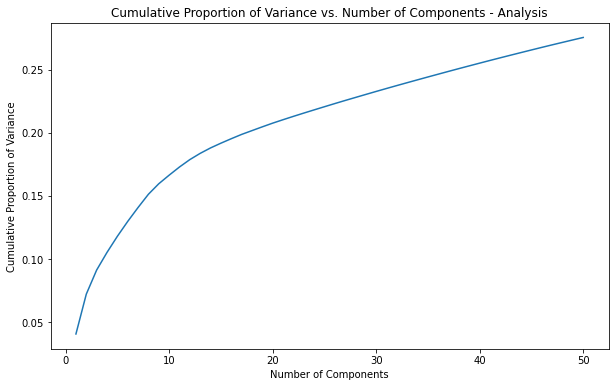

In [119]:
fig = plt.figure(figsize = (10, 6))
variances = pca_obj.explained_variance_ratio_
cdf_variance = np.cumsum(variances)
plt.plot(list(range(1, len(cdf_variance) + 1)), cdf_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Proportion of Variance")
plt.title("Cumulative Proportion of Variance vs. Number of Components - Analysis")
plt.show()

In [120]:
print(f"The Cumulative Proportion of Variance captured by the first 20 principal components is: " + \
      f"{cdf_variance[19]}")

The Cumulative Proportion of Variance captured by the first 20 principal components is: 0.20765297035775668


**Q3. For the first principal component, report the top 10 loadings (weights) and their corresponding gene names.** In other words, which 10 genes are weighted the most in the first principal component?

In [129]:
feature_name_first_pc_map = list(zip(cell_gene_counts_df.columns, pca_obj.components_[0]))
top_10_weights_first_pc = sorted(feature_name_first_pc_map, key = lambda x : x[1])
top_10_weights_first_pc.reverse()

In [130]:
print(f"Top 10 gene weights with their corresponding gene names are as follows: ")
for gene_name, weight_in_pc_1 in top_10_weights_first_pc[:10]:
    print(f"{gene_name}: {weight_in_pc_1}")

Top 10 gene weights with their corresponding gene names are as follows: 
Nsg2: 0.026673155895547074
St8sia3: 0.026594676050094218
Ptpn5: 0.02658800946243798
Kcnj4: 0.02653923817164229
Rasgef1a: 0.02634748212555478
Camkv: 0.02622075238050726
Hpca: 0.0261731140046593
Cpne5: 0.02602184941120197
Nrsn2: 0.025978972935927516
Erc2: 0.025852558650618522


**Q4. Plot the projection of the data onto the first two principal components using a scatter plot.**

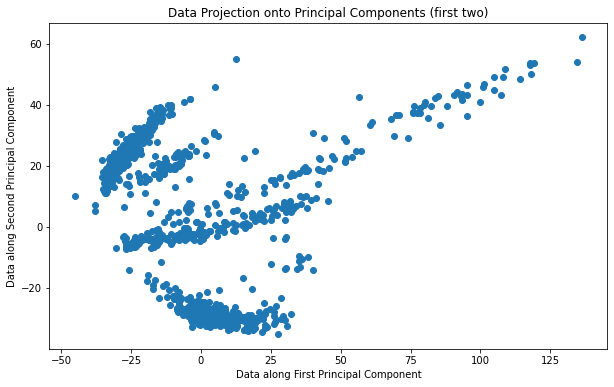

In [131]:
fig = plt.figure(figsize = (10, 6))

plt.scatter(pcs_cell_gene_counts[:, 0], pcs_cell_gene_counts[:, 1])
plt.xlabel("Data along First Principal Component")
plt.ylabel("Data along Second Principal Component")
plt.title("Data Projection onto Principal Components (first two)")
plt.show()

**Q5. Now, use a small multiple of four scatter plots to make the same plot as above, but colored by four annotations in the metadata: cell_ontology_class, subtissue, mouse.sex, mouse.id. Include a legend for the labels.** For example, one of the plots should have points projected onto PC 1 and PC 2, colored by their cell_ontology_class.

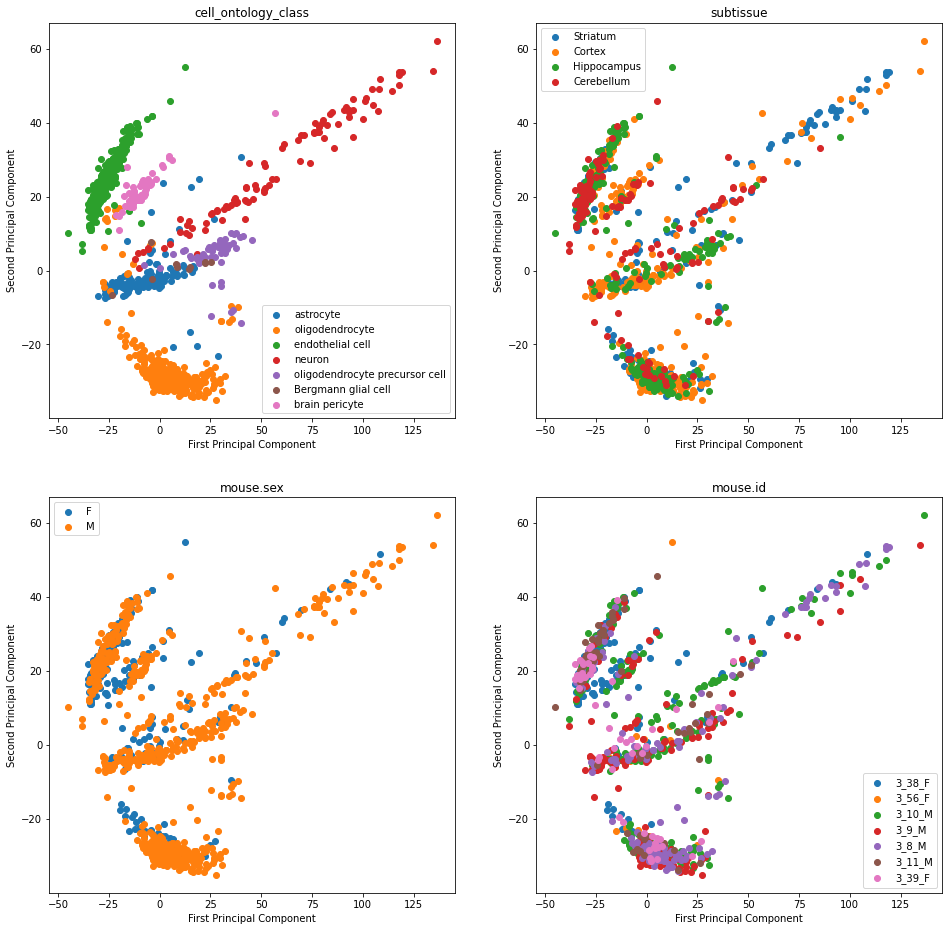

In [136]:
fig, axes = plt.subplots(2, 2, figsize = (16, 16))
metadata_col_names = ['cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id']
metadata_col_idx = 0

for row_idx in range(0, 2):
    for col_idx in range(0, 2):
        curr_col_vals = cell_metadata_df[metadata_col_names[metadata_col_idx]].unique()
        for col_value in curr_col_vals:
            pc1 = pcs_cell_gene_counts[cell_metadata_df[metadata_col_names[metadata_col_idx]] == col_value, 0]
            pc2 = pcs_cell_gene_counts[cell_metadata_df[metadata_col_names[metadata_col_idx]] == col_value, 1]
            axes[row_idx, col_idx].scatter(pc1, pc2, label = col_value)
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].set_title(metadata_col_names[metadata_col_idx])
        axes[row_idx, col_idx].set_xlabel("First Principal Component")
        axes[row_idx, col_idx].set_ylabel("Second Principal Component")
        metadata_col_idx += 1

plt.show()

**Q6. Based on the plots above, the first two principal components correspond to which aspect of the cells? What is the intrinsic dimension that they are describing?**

The first two principal components seem to correspond to the "cell_ontology" aspect of the cells.
Intrinsic Dimension:

## 2 K-means

While the annotations provide high-level information on cell type (e.g. cell_ontology_class has 7 categories), we may also be interested in finding more granular subtypes of cells. To achieve this, we will use K-means clustering to find a large number of clusters in the gene expression dataset. Note that the original gene expression matrix had over 18,000 noisy features, which is not ideal for clustering. So, we will perform K-means clustering on the first 20 principal components of the dataset.

**Q7. Implement a `kmeans` function which takes in a dataset `X` and a number of clusters `k`, and returns the cluster assignment for each point in `X`. You may NOT use sklearn for this implementation. Use lecture 6, slide 14 as a reference.**

In [141]:
def kmeans(X, k, iters=10):
    '''Groups the points in X into k clusters using the K-means algorithm.

    Parameters
    ----------
    X : (m x n) data matrix
    k: number of clusters
    iters: number of iterations to run k-means loop

    Returns
    -------
    y: (m x 1) cluster assignment for each point in X
    '''
    # Randomly choose initial centroids
    centroid_indices = np.random.choice(len(X), k, replace = False)
    centroids = X[centroid_indices, :]
    iteration = 0
    
    while iteration <= iters:
        distances = compute_distances(X, centroids)
        new_clusters = np.array([np.argmin(distance) for distance in distances])
        
        # finding new centroids
        centroids = []
        for cluster_idx in range(k):
            new_centroid = X[new_clusters == cluster_idx].mean(axis = 0)
            centroids.append(new_centroid)
        
        centroids = np.vstack(centroids)
        iteration += 1
    
    distances = compute_distances(X, centroids)
    new_clusters = np.array([np.argmin(distance) for distance in distances])
    
    return new_clusters
    
def compute_distances(data, centroids):
    distances = list()
    
    for point in data:
        distances_from_centroids = list()
        for centroid_idx in range(len(centroids)):
            distances_from_centroids.append(np.linalg.norm(point - centroids[centroid_idx])) 
        distances.append(distances_from_centroids)
        
    return distances

Before applying K-means on the gene expression data, we will test it on the following synthetic dataset to make sure that the implementation is working.

Text(0, 0.5, '$x_2$')

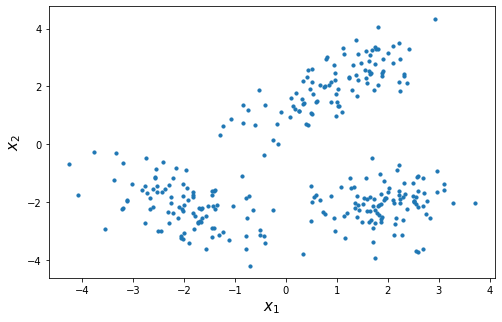

In [142]:
np.random.seed(0)
x_1 = np.random.multivariate_normal(mean=[1, 2], cov=np.array([[0.8, 0.6], [0.6, 0.8]]), size=100)
x_2 = np.random.multivariate_normal(mean=[-2, -2], cov=np.array([[0.8, -0.4], [-0.4, 0.8]]), size=100)
x_3 = np.random.multivariate_normal(mean=[2, -2], cov=np.array([[0.4, 0], [0, 0.4]]), size=100)
X = np.vstack([x_1, x_2, x_3])

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

**Q8. Apply K-means with k=3 to the synthetic dataset above. Plot the points colored by their K-means cluster assignments to verify that your implementation is working.**

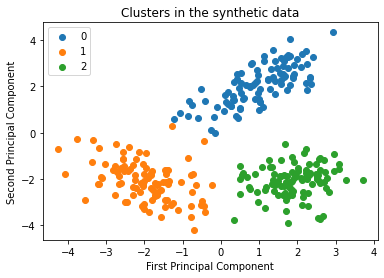

In [143]:
k = 3
labels_found = kmeans(X, k)
labeled_synthetic_data = np.column_stack([X, labels_found])

for idx in range(k):
    pc1 = labeled_synthetic_data[labeled_synthetic_data[:, -1] == idx][:, 0]
    pc2 = labeled_synthetic_data[labeled_synthetic_data[:, -1] == idx][:, 1]
    plt.scatter(pc1, pc2, label = idx)
    
plt.xlabel("First Principal Component", fontsize = 10)
plt.ylabel("Second Principal Component", fontsize = 10)
plt.title("Clusters in the synthetic data")
plt.legend()
plt.show()

**Q9. Use K-means with k=20 to cluster the first 20 principal components of the gene expression data.**

In [145]:
k = 20
gene_labels = kmeans(pcs_cell_gene_counts[:, :20], k, 25)
print(gene_labels[:100])

[13  0  2 16  0  0  1 11 10 14  1  6  9  6  1  2  2  3 14  3 14  6  6 11
  3 10  9  3  4 11  0  6 16  1  3 10 11  6  9  2  8  3  3 14 14 11  9  2
 17  9  2  4 10  2 16 14  2  8 17  7  2  7 11  0  7 19  9  7  1 10  4 11
  0 14 18  3 11  6  4  0  9 10  6 11 11  0 18 11  9 11  4 14  3 11  3 10
  2 19  3  8]


## 3 t-SNE

In this final section, we will visualize the data again using t-SNE - a non-linear dimensionality reduction algorithm. You can learn more about t-SNE in this interactive tutorial: https://distill.pub/2016/misread-tsne/.

**Q10. Use t-SNE to reduce the first 20 principal components of the gene expression dataset to two dimensions. You may use `sklearn.manifold.TSNE`.** Note that it is recommended to first perform PCA before applying t-SNE to suppress noise and speed up computation.

In [33]:
### Your code here

**Q11. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions.**

In [34]:
### Your code here

**Q12. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions, with points colored by their cluster assignments from part 2.**

In [35]:
### Your code here

**Q13. Why is there overlap between points in different clusters in the t-SNE plot above?**

In [36]:
### Your answer here

These 20 clusters may correspond to various cell subtypes or cell states. They can be further investigated and mapped to known cell types based on their gene expressions (e.g. using the K-means cluster centers). The clusters may also be used in downstream analysis. For instance, we can monitor how the clusters evolve and interact with each other over time in response to a treatment.